In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import plot_confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [38]:
df = pd.read_csv('C:/Users/Avalon/Documents/Digital Skola/Notebook/Dataset_9 - Banking.csv')

In [39]:
def show_cm(model, aktual, prediksi, name, color):
    plt.figure(figsize=(10,5))
    plot_confusion_matrix(model, aktual, prediksi, cmap=color)
    plt.title(name)
    plt.grid(False)
    plt.show()

In [40]:
df = df.drop([
    'RowNumber',
    'CustomerId',
    'Surname'
], axis=1)

In [41]:
df = pd.get_dummies(df)

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [42]:
y = df["Exited"]

X = df.drop(labels = ["Exited"],axis = 1)

In [43]:
# Splitting data into testing and training data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1992)

In [44]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=5, sampling_strategy=1)
X_train_smo, y_train_smo = smote.fit_resample(X_train, y_train)

In [45]:
y_train.value_counts()

0    5573
1    1427
Name: Exited, dtype: int64

In [46]:
y_train_smo.value_counts()

1    5573
0    5573
Name: Exited, dtype: int64

In [47]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_smo = sc.fit_transform(X_train_smo)
X_test = sc.transform(X_test)

In [48]:
# Cross validate model with Kfold stratified cross validation
kfold = StratifiedKFold(n_splits=5)

cross_val_score(LogisticRegression(), X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4)
cross_val_score(RandomForestClassifier(), X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4)
cross_val_score(KNeighborsClassifier(), X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4)
cross_val_score(SVC(), X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4)
cross_val_score(XGBClassifier(), X_train_smo, y = y_train_smo, scoring = "f1", cv = kfold, n_jobs=4)

array([0.63408959, 0.87580497, 0.93339063, 0.93503073, 0.92888118])

In [49]:
# LogisticRegression

LR = LogisticRegression()

param_grid = {
                  "C":np.logspace(-3,3,7), 
                  "penalty":["l1","l2"]
}

gs_LR = GridSearchCV(LR, param_grid = param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gs_LR.fit(X_train_smo,y_train_smo)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='f1', verbose=1)

In [50]:
y_pred = gs_LR.predict(X_test)

In [51]:
y_test.dtype

dtype('int64')

In [52]:
y_pred.dtype

dtype('int64')

In [53]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2390
           1       0.50      0.44      0.47       610

    accuracy                           0.80      3000
   macro avg       0.68      0.66      0.67      3000
weighted avg       0.79      0.80      0.79      3000


Confusion Matrix:
[[2114  276]
 [ 339  271]]


<Figure size 720x360 with 0 Axes>

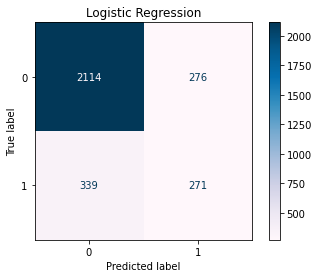

In [54]:
show_cm(gs_LR, X_test, y_test, 'Logistic Regression', 'PuBu')

In [55]:
# RandomForest 

RFC = RandomForestClassifier()


param_grid = {
              "max_depth": [4,5,7],
              "max_features": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[80,100,120],
              "criterion": ["gini"]
}


gs_RFC = GridSearchCV(RFC,param_grid = param_grid, cv=kfold, scoring="f1", n_jobs= 4, verbose = 1)

gs_RFC.fit(X_train_smo,y_train_smo)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'bootstrap': [False], 'criterion': ['gini'],
                         'max_depth': [4, 5, 7], 'max_features': [1, 3, 10],
                         'min_samples_leaf': [1, 3, 10],
                         'n_estimators': [80, 100, 120]},
             scoring='f1', verbose=1)

In [56]:
y_pred = gs_RFC.predict(X_test)

In [57]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2390
           1       0.58      0.60      0.59       610

    accuracy                           0.83      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.83      0.83      0.83      3000


Confusion Matrix:
[[2122  268]
 [ 243  367]]


<Figure size 720x360 with 0 Axes>

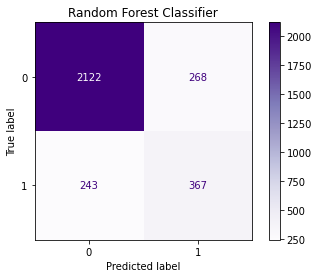

In [76]:
show_cm(gs_RFC, X_test, y_test, 'Random Forest Classifier', plt.cm.Purples)

In [59]:
# KNeighbors

KNN = KNeighborsClassifier()

k_grid={
        'n_neighbors':np.arange(2,20)
}

gs_KNN=GridSearchCV(KNN, k_grid, cv=kfold, refit=True, n_jobs=4)

gs_KNN.fit(X_train_smo,y_train_smo)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])})

In [60]:
y_pred = gs_KNN.predict(X_test)

In [61]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2390
           1       0.60      0.41      0.48       610

    accuracy                           0.82      3000
   macro avg       0.73      0.67      0.69      3000
weighted avg       0.81      0.82      0.81      3000


Confusion Matrix:
[[2222  168]
 [ 361  249]]


<Figure size 720x360 with 0 Axes>

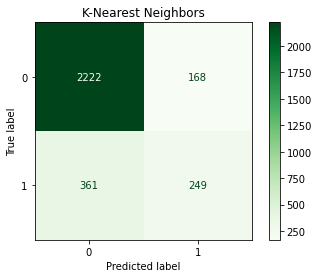

In [62]:
show_cm(gs_KNN, X_test, y_test, 'K-Nearest Neighbors', plt.cm.Greens)

In [63]:
# SVC
SVM = SVC()


param_grid = {
                'C': [0.1, 1, 10], 
                'gamma': [0.01, 0.1, 1],
                'kernel': ['rbf']
}

gs_SVM = GridSearchCV(SVM, param_grid, cv=kfold, n_jobs=4)

gs_SVM.fit(X_train_smo,y_train_smo)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1],
                         'kernel': ['rbf']})

In [64]:
y_pred = gs_SVM.predict(X_test)

In [65]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2390
           1       0.66      0.53      0.59       610

    accuracy                           0.85      3000
   macro avg       0.78      0.73      0.75      3000
weighted avg       0.84      0.85      0.84      3000


Confusion Matrix:
[[2226  164]
 [ 286  324]]


<Figure size 720x360 with 0 Axes>

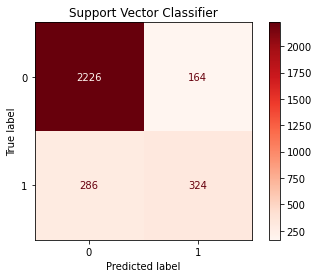

In [66]:
show_cm(gs_SVM, X_test, y_test, 'Support Vector Classifier', plt.cm.Reds)

In [67]:
# XGB

XGB = XGBClassifier()

param_grid = {
                'n_estimators': [50,80,100,120], 
                'gamma': [0.01,0.001,0.001], 
                'max_depth': [5,6,7,8],
                'min_child_weight': [1,5,8,10], 
                'learning_rate': [0.05,0.1,0.2]
}

gs_XGB = GridSearchCV(estimator = XGB, param_grid =  param_grid,  cv=kfold, n_jobs=4)

gs_XGB.fit(X_train_smo,y_train_smo)

[14:35:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, mi...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                           

In [68]:
y_pred = gs_XGB.predict(X_test)

In [69]:
print("\nClassification Report:\n")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      2390
           1       0.62      0.57      0.59       610

    accuracy                           0.84      3000
   macro avg       0.76      0.74      0.75      3000
weighted avg       0.84      0.84      0.84      3000


Confusion Matrix:
[[2182  208]
 [ 265  345]]


<Figure size 720x360 with 0 Axes>

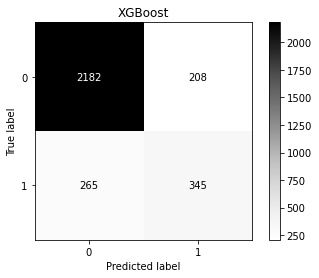

In [70]:
show_cm(gs_XGB, X_test, y_test, 'XGBoost', plt.cm.Greys)